# AAM Demo Script


## Initialization and loading data

In [46]:
import numpy as np
import scipy.io as sio
import scipy
import matplotlib.pyplot as plt
import math
%reload_ext autoreload
%autoreload 2

IMG_SET_ID = 4 # 4 # 7
path = "data/"
dist_name = path + "distances_" + str(IMG_SET_ID) + ".mat"
PSF_name  = path + "GaussStd2Color_" + str(IMG_SET_ID) + ".mat"
PSF_NIR_name = path + "GaussStd2Nir_" + str(IMG_SET_ID) + ".mat"

mat_dist = sio.loadmat(dist_name)
mat_PSF = sio.loadmat(PSF_name)
mat_PSF_NIR = sio.loadmat(PSF_NIR_name)

distances = mat_dist['distancesCol']
PSF       = mat_PSF['GaussStd2Color']
PSF_NIR   = np.squeeze(mat_PSF_NIR['GaussStd2Nir'])
PSF[:,3] = PSF_NIR

assert distances.shape[0] == PSF.shape[0]
assert distances.shape[0] == PSF_NIR.shape[0]
print('loaded experimental data from {} distances and {} channels.'.format(*PSF.shape))

#distances2 = np.squeeze(distances)
#diff_dist = [x - distances2[i - 1] for i, x in enumerate(distances2) if i > 0]
#b = np.zeros((50, 2))
#b[:,0] = diff_dist
#b[:,1] = range(len(diff_dist))
#print(b)

loaded experimental data from 51 distances and 4 channels.


## Resample data uniformly. 

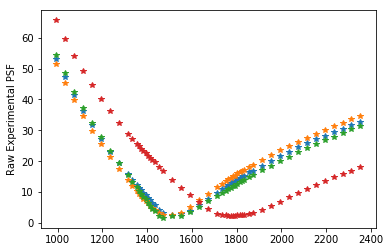

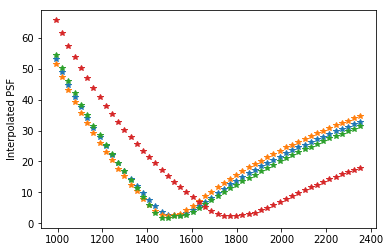

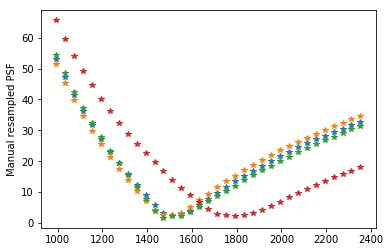

In [47]:
from aam import make_uniform
    
plt.plot(distances, PSF, '*') 
plt.ylabel('Raw Experimental PSF')
plt.show()

distances_uniform, PSF_uniform = make_uniform(distances, PSF, 'uniform')

plt.figure()
plt.plot(distances_uniform, PSF_uniform, '*')
plt.ylabel('Interpolated PSF')
plt.show()

if IMG_SET_ID == 4:
    distances_uniform, PSF_uniform = make_uniform(distances, PSF, 'manual')

if IMG_SET_ID == 7:
    distances_uniform = distances
    PSF_uniform = PSF

plt.figure()
plt.plot(distances_uniform, PSF_uniform, '*')
plt.ylabel('Manual resampled PSF')
plt.show()

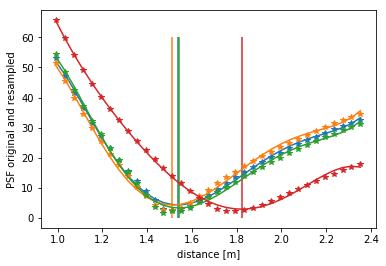

In [48]:
from aam import polynomial_fitting, get_focus_distances
from aam import compute_aam

def plot_fitting(polyParams, x0, PSF):
    plt.figure()
    for i in range(polyParams.shape[0]):
        f = np.poly1d(polyParams[i])
        p = plt.plot(x, f(x) , '-')
        color = p[0].get_color()
        plt.plot(x, PSF[:, i], '*', color=color)
        plt.vlines(x0[i],ymin=0, ymax=60, color=color)
    plt.xlabel('distance [m]')
    plt.ylabel('PSF original and resampled')
    plt.show()

scaling = 1000
x = np.squeeze(distances_uniform/scaling)

polyParams = polynomial_fitting(x, PSF_uniform, degree=5)
x0 = get_focus_distances(polyParams, bounds=(x[0], x[-1]))
plot_fitting(polyParams, x0, PSF_uniform)

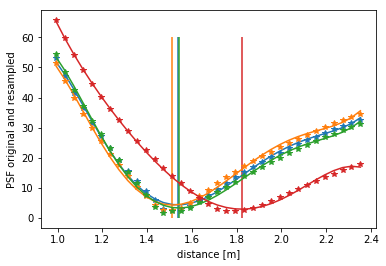

In [49]:
PSF_uniform_noisy = PSF_uniform.copy()
scale = 1e-5
PSF_uniform_noisy += np.random.normal(scale=scale*PSF_uniform, size=PSF_uniform.shape)
polyParams_noisy = polynomial_fitting(x, PSF_uniform_noisy, degree=5)
x0_noisy = get_focus_distances(polyParams_noisy, bounds=(x[0], x[-1]))
plot_fitting(polyParams_noisy, x0_noisy, PSF_uniform_noisy)

In [58]:
num_colors = 4
num_alphas = 51
alphaList = np.linspace(0.2, 0.5, num_alphas)

AAM = compute_aam(polyParams[:num_colors, :], x0[:num_colors], alphaList)
AAM_noisy = compute_aam(polyParams_noisy[:num_colors, :], x0_noisy[:num_colors], alphaList)

AAM /= scaling
AAM_noisy /= scaling

AAM = np.log10(AAM)
AAM_noisy = np.log10(AAM_noisy)

In [60]:
from pipeline import pipeline

pipeline(IMG_SET_ID = 4, scale=1e-3, num_colors=4, degree=5)
pipeline(IMG_SET_ID = 7, scale=1e-3, num_colors=4, degree=5)

loaded experimental data from 51 distances and 4 channels.
alpha 	 & AAM (AAM noisy scale=0.001) \\
0.20 	 &     4.59 (    4.59, 6.82e-04) \\
0.35 	 &     5.21 (    5.21, 5.66e-04) \\
0.50 	 &     5.78 (    5.77, 4.89e-04) \\
loaded experimental data from 28 distances and 4 channels.
alpha 	 & AAM (AAM noisy scale=0.001) \\
0.20 	 &     4.83 (    4.83, 9.00e-04) \\
0.35 	 &     5.44 (    5.45, 7.80e-04) \\
0.50 	 &     6.00 (    6.00, 6.97e-04) \\
